# <span style="color:green">Algoritmi Genetici per Serie Finanziarie</span>

- Compattamento Codice.
- Aggiunta funzione "load_data_intraday".
- Aggiunta funzione "create_rules".
- Aggiunta INSTABILITY_FACTOR nella funzione "all_gains".
- Aggiunta INSTRUMENT nella funzione "operation_gain".
- Aggiunta Fitness Functions alternative e composte.

In [1]:
!python --version

Python 3.8.12


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba

In [3]:
%run ./engine_gandalf_wintermute.py
%run ./functions_gandalf_wintermute.py

5.3.1


### <span style="color:red">Aggiungiamo una funzione per il caricamento della serie finanziaria intraday:</span>

In [4]:
from scipy.stats import kurtosis, skew
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm          
           
def profitto(operations):
    return operations.sum()

def performance_report_gen(tradelist):
    res=pd.DataFrame()
    d = {"Profit": profitto(tradelist),
         "MaxDD" : max_draw_down(tradelist),
         "Operations":operation_number(tradelist),
         "AverageTrade": avg_trade(tradelist),
         "ProfitFactor": profit_factor(tradelist),
         "PctWin": percent_win(tradelist),
         "KestnerRatio": kestner_ratio(tradelist),
         "STD_Daily" : tradelist.resample("D").sum().std(),
         "Skew" : skew(tradelist.values),
         "Reward_Risk_Ratio": reward_risk_ratio(tradelist)}
    res=pd.DataFrame(data=d,index=[0])
    return res 

def test_time_frame(tf):
    tf=tf.lower()
    ls_tf=["1min","5min","15min","30min","60min","120min","240min","480min","1380min","1440min"]
    test_ok=0
    for e in ls_tf:
        if e == tf:
            tf_ok=e
            test_ok=1
            break
    if test_ok == 0:
            print("ERRORE - Solo time frame a: ",ls_tf," in ingresso")
    else:
        tf_ok=tf_ok.split("min")[0]
        return int(tf_ok)
    
def resample_standard_session(original_tf,resample_tf,dataset):
    
    original_tf=test_time_frame(original_tf)
    resample_tf=test_time_frame(resample_tf)
    df_0=dataset.copy()
    
    df_0.index=df_0.index - pd.DateOffset(minutes=original_tf)
    df_resample=df_0.resample(str(resample_tf)+'Min').agg({'open' : 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last','volume':'sum'})
    
    if resample_tf == "1440" :
        df_resample = df_resample
    else:
        df_resample.index=df_resample.index + pd.DateOffset(minutes=resample_tf)
        
    df_resample=df_resample.dropna()
    return df_resample

def load_data_intraday_fast(filename):
    data=pd.read_csv(filename,engine="pyarrow")
    data.set_index(["date_time"],inplace=True)
    data.index=pd.to_datetime(data.index)
    return data

def resample_custom_session(original_tf,resample_tf,dataset,start_time,end_time):
    
    original_tf=test_time_frame(original_tf)
    resample_tf=test_time_frame(resample_tf)
    df_0=dataset.copy()
    
    df_0.index=df_0.index - pd.DateOffset(minutes=original_tf)
    
    test_start_time=0
    if len(start_time) == 4:
        st_h=start_time[:2]
        st_m=start_time[2:]
        test_start_time=1
        
    test_end_time=0
    if len(end_time) == 4:
        en_h=end_time[:2]
        en_m=end_time[2:]
        test_end_time=1

    if (test_start_time==0)|(test_end_time==0):
        print("ERRORE - controlla gli orari di start & end")
    else:

        dati=df_0.loc[(df_0.index.time>=datetime.time(int(st_h), int(st_m)))&(df_0.index.time<=datetime.time(int(en_h), int(en_m)))]
        dati= dati.resample(str(resample_tf)+'Min',origin=st_h+":"+st_m+':00').agg({'open': 'first','high': 'max','low':'min','close':'last','volume':'sum'}).dropna()
        dati.index=dati.index + pd.DateOffset(minutes=resample_tf)
        
        test_h=sorted(list(set(dati.index.time)))
        
        time1 = datetime.time(int(en_h),int(en_m))
        timedelta = datetime.timedelta(minutes=original_tf)
        tmp_datetime = datetime.datetime.combine(datetime.date(1, 1, 1), time1)
        time2 = (tmp_datetime - timedelta).time()
        
        dati1=df_0.loc[(df_0.index.time>=test_h[-2])&(df_0.index.time<=time2)]
        dati1= dati1.resample("D").agg({'open': 'first','high': 'max','low':'min','close':'last','volume':'sum'}).dropna()
        dati1.index=dati1.index + pd.DateOffset(hours=int(en_h),minutes=int(en_m))

        custom_df=dati.loc[dati.index.time!=test_h[-1]].dropna()
        custom_df=pd.concat([custom_df,dati1])
        custom_df=custom_df.sort_index(ascending=True)
        return custom_df
    
def carica_storico(file_name,uct_offset,type_session,resample_tf,IS,OOS,custom_session_start,custom_session_stop,noise,pct_noise):
    import os
    import talib as ta
    
    os.chdir(dir_history)
    data = load_data_intraday_fast(file_name)  
    print("Caricato storico")
    data = data.sort_index(ascending=True)
    data.index = data.index.tz_localize('Etc/Zulu')
    data.index = data.index.tz_convert(uct_offset )
    data.index = data.index.tz_localize(None)
    data = data[data!=0]
    #data = data.fillna(method="ffill")
    data = data.iloc[1:-1]
    print("Resample dei dati")
    if type_session == 1:
        dataset=resample_custom_session("5min",resample_tf ,data,custom_session_start,custom_session_stop) 
    if type_session == 0:    
        dataset=resample_standard_session("5min",resample_tf,data)
        
    if noise == 1:
        print("AGGIUNGO RUMORE")
        dataset=add_noise(dataset.open, dataset.high, dataset.low, dataset.close,dataset.volume, pct_noise)

    dataset = dataset.loc[IS:OOS]
    dataset["dayofweek"] = dataset.index.dayofweek
    dataset["day"] = dataset.index.day
    dataset["month"] = dataset.index.month
    dataset["year"] = dataset.index.year
    dataset["dayofyear"] = dataset.index.dayofyear
    dataset["week"] = dataset.index.week
    dataset["hour"] = dataset.index.hour
    dataset["minute"] = dataset.index.minute
    dataset["daily_open"] = daily_open(dataset,1)
    dataset["daily_high"] = daily_high(dataset,1)
    dataset["daily_low"] = daily_low(dataset,1)
    dataset["daily_close"] = daily_close(dataset,1)
    
    dataset.close.plot(figsize = (14, 8), grid = True, color = "green",title=SIMBOLO+"_"+RESAMPLE_TF)
    print("Fatto")
    return dataset
    
def environment(simbolo,type_session,resample_tf,start_date,end_date):
               
    file_name = check_history_name(simbolo,dir_history)

    IS = start_date
    OOS = end_date

    bigpointvalue=valori[valori.Physical==simbolo].BigPointValue.values[0]
    tick=valori[valori.Physical==simbolo].Tick.values[0]
    utc_offset = valori[valori.Physical==simbolo].Exchange_Time.values[0]
    custom_session_start = "0"+str(valori[valori.Physical==simbolo]["Custom Open"].values[0])
    custom_session_stop = str(valori[valori.Physical==simbolo]["Custom Close"].values[0])
    costi=valori[valori.Physical==simbolo].Cost.values[0]

    dataset = carica_storico(file_name,utc_offset,type_session,resample_tf,IS,OOS,custom_session_start,custom_session_stop,0,0)
    
    return dataset , bigpointvalue , tick , utc_offset , custom_session_start , custom_session_stop , costi 

def check_history_name(file_name,dir_history):
    import os
    storici = os.listdir(dir_history)
    for e in storici:
        x=e.split("_")[0]
        x=x.replace("@","")
        if x == file_name:
            file_name=e
            print(file_name)
            break
    return file_name

def performance_report_gen(tradelist):
    res=pd.DataFrame()
    d = {"Profit": profitto(tradelist),
         "MaxDD" : max_draw_down(tradelist),
         "Operations":operation_number(tradelist),
         "AverageTrade": avg_trade_2(tradelist),
         "ProfitFactor": profit_factor_2(tradelist),
         "PctWin": percent_win(tradelist),
         "KestnerRatio": kestner_ratio(tradelist),
         "STD_Daily" : tradelist.resample("D").sum().std(),
         "Skew" : skew(tradelist.values),
         "Reward_Risk_Ratio": reward_risk_ratio(tradelist)}
    
    res=pd.DataFrame(data=d,index=[0])
    return res 

def avg_trade_2(operations):
    return round(operations.mean(),2)

def gross_profit_2(operations):
    return round(operations[operations > 0].sum(),2)
    
def gross_loss_2(operations):
    return round(operations[operations <= 0].sum(),2)
    
def profit_factor_2(operations):
    a = gross_profit_2(operations)
    b = gross_loss_2(operations)
    if b != 0:
        return round(abs(a / b), 2)
    else:
        return round(abs(a / 0.00000001), 2)

In [5]:
dir_home=(r"C:\Users\Drako\Genetico_V3")
dir_history=(r"C:\Users\Drako\TS_API")

In [6]:
def info_simboli():
    
    valori=pd.read_csv("Markets_Specifications_Live.csv",sep=",",encoding='cp1252')
    valori.reset_index(inplace=True)
    valori.Exchange_Time=np.where(valori.Exchange_Time==-6,"CST6CDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="-5","EST5EDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="1","CET",valori.Exchange_Time)
    valori["Simbolo"]=valori.Physical
    valori=valori[(valori.Physical!="KC")&(valori.Physical!="TY")]
    return valori

os.chdir(dir_home)
valori=info_simboli()

valori

,index,SecurityName,Exchange Code,Physical,Underlying Future,MarketTypeName,Exchange,BigPointValue,Unit,Margins,Regular Open,Regular Close,Custom Open,Custom Close,Tick,Cost,AMP_simb,Exchange_Time,TT_Code,Simbolo
0,0,Australian Dollar,6A,AD,Australian Dollar,Currencies,CME,100000,0.00,2000,1700,1600,720,1400,0.000100,25,DA6,CST6CDT,6A,AD
1,1,British Pound,6B,BP,British Pound,Currencies,CME,62500,0.00,2500,1700,1600,720,1400,0.000100,25,BP6,CST6CDT,6B,BP
2,2,Crude Oil,CL,CL,Crude Oil,Energies,CME,1000,0.10,6000,1800,1700,900,1430,0.010000,50,CLE,EST5EDT,CL,CL
3,3,Euro FX,6E,EC,Euro FX,Currencies,CME,125000,0.00,3000,1700,1600,720,1400,0.000100,25,EU6,CST6CDT,6E,EC
4,4,E-mini S&P 500,ES,ES,E-mini S&P 500,Stock Indices,CME,50,0.10,12000,1700,1600,830,1515,0.250000,25,EP,CST6CDT,ES,ES
5,5,DAX Futures,FDAX,FDAX,DAX Futures,Stock Indices,EUREX,25,0.20,30000,110,2200,800,2200,0.500000,50,FDX,CET,FDAX,FDAX
6,6,EURO STOXX 50 Index,FESX,FESX,EURO STOXX 50 Index,Stock Indices,EUREX,5,0.00,3000,110,2200,800,2200,0.500000,20,DSX,CET,FESX,FESX
7,7,Euro Bund,FGBL,FGBL,Euro Bund,Fixed Income,EUREX,1000,0.00,2400,110,2200,800,2200,0.010000,20,DB,CET,FGBL,FGBL
8,8,Gold,GC,GC,Gold,Metals,CME,100,0.10,8500,1800,1700,800,1500,0.100000,60,GCE,EST5EDT,GC,GC
9,9,Copper,HG,HG,Copper,Metals,CME,25000,0.00,7500,1800,1700,800,1500,0.050000,60,CPE,EST5EDT,HG,HG


@S_5Minute_2022-07-12.csv
Caricato storico
Resample dei dati
Fatto


,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,week,hour,minute,daily_open,daily_high,daily_low,daily_close
date_time,,,,,,,,,,,,,,,,,
2019-12-26 16:00:00,653.75,656.00,652.75,653.50,15032.0,3,26,12,2019,360,52,16,0,649.00,653.50,645.00,653.00
2019-12-27 00:00:00,653.00,655.50,652.25,655.50,3362.0,4,27,12,2019,361,52,0,0,653.75,656.00,652.75,653.50
2019-12-27 08:00:00,655.25,657.25,654.25,655.00,6426.0,4,27,12,2019,361,52,8,0,653.75,656.00,652.75,653.50
2019-12-27 16:00:00,654.75,657.75,645.75,649.50,53104.0,4,27,12,2019,361,52,16,0,653.75,656.00,652.75,653.50
2019-12-30 00:00:00,648.75,655.25,646.75,654.50,7760.0,0,30,12,2019,364,1,0,0,653.00,657.75,645.75,649.50
2019-12-30 08:00:00,654.50,657.75,653.00,657.50,8622.0,0,30,12,2019,364,1,8,0,653.00,657.75,645.75,649.50
2019-12-30 16:00:00,657.25,660.25,655.50,659.75,51303.0,0,30,12,2019,364,1,16,0,653.00,657.75,645.75,649.50
2019-12-31 00:00:00,658.75,659.25,657.50,658.25,3150.0,1,31,12,2019,365,1,0,0,648.75,660.25,646.75,659.75
2019-12-31 08:00:00,658.25,660.50,657.50,659.25,4803.0,1,31,12,2019,365,1,8,0,648.75,660.25,646.75,659.75


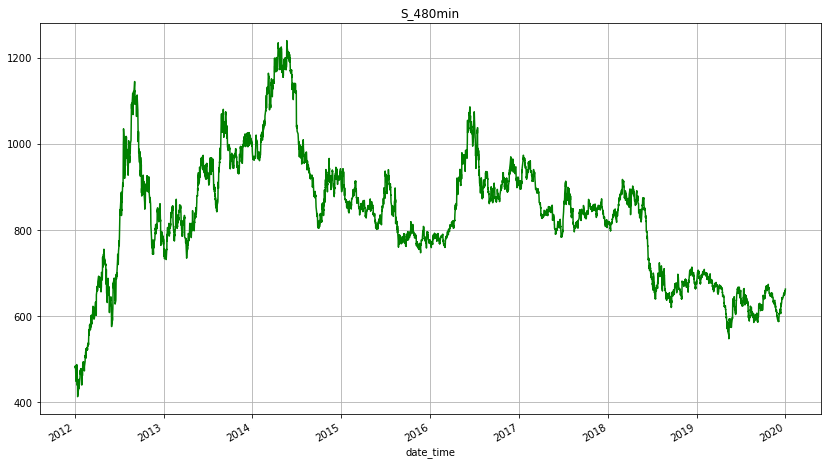

In [7]:
SIMBOLO = "S"

TYPE_SESSION = 0    
RESAMPLE_TF = "480min"  ### RESAMPLE POSSIBILI "5min","15min","30min","60min","120min","240min","480min","1380min","1440min"]
START_DATE = "2012-01-01"
END_DATE = "2020-01-01"

dataset , bigpointvalue , tick , utc_offset , custom_session_start , custom_session_stop , costi  = environment(SIMBOLO,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE)
dataset.tail(10)

In [8]:
def apply_indicator(dataset):
    
    log_price=["OpenToLowLog",
    "OpenToAvgPriceLog",
    "OpenToMedPriceLog",
    "OpenToOpenLog",
    "OpenToMedBodyPriceLog",
    "CloseToMedPriceLog",
    "CloseToCloseLog",
    "CloseToLowLog",
    "CloseToAvgPriceLog",
    "CloseToMedBodyPriceLog",
    "HighToCloseLog",
    "HighToOpenLog",
    "HighToMedBodyPriceLog",
    "HighToMedPriceLog",
    "HighToAvgPriceLog",
    "HighToHighLog",
    "LowToLowLog",
    "AvgPriceToMedPriceLog",
    "AvgPriceToLowLog",
    "AvgPriceToAvgPriceLog",
    "AvgPriceToMedBodyPriceLog",
    "MedPriceToLowLog",
    "MedBodyPriceToLowLog",
    "MedPriceToMedBodyPriceLog",
    "MedPriceToMedPriceLog",
    "MedBodyPriceToMedBodyPriceLog",
    "RangeLog",
    "BodyLog",
    "BodyToRangeLog"]

    for e in log_price:
        dataset[e]=eval(e+"(dataset)")
        
    return dataset , log_price

In [9]:
dataset , log_price =apply_indicator(dataset)

dataset.dropna(inplace = True)
dataset.head()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,...,AvgPriceToAvgPriceLog,AvgPriceToMedBodyPriceLog,MedPriceToLowLog,MedBodyPriceToLowLog,MedPriceToMedBodyPriceLog,MedPriceToMedPriceLog,MedBodyPriceToMedBodyPriceLog,RangeLog,BodyLog,BodyToRangeLog
date_time,,,,,,,,,,,,,,,,,,,,,
2012-01-04 00:00:00,477.25,480.25,475.75,480.00,2313.0,2,4,1,2012,4,...,-0.018770,-0.000653,0.004718,0.006025,-0.001307,-0.023263,-0.014262,0.009414,0.005746,-0.492476
2012-01-04 08:00:00,479.75,490.00,477.25,480.25,10692.0,2,4,1,2012,4,...,0.007291,0.003769,0.013269,0.005746,0.007524,0.011699,0.002869,0.026365,0.001042,-3.238678
2012-01-04 16:00:00,479.75,491.00,477.75,485.75,54801.0,2,4,1,2012,4,...,0.003626,0.001682,0.013772,0.010411,0.003360,0.001550,0.005713,0.027357,0.012429,-0.792238
2012-01-06 00:00:00,463.75,467.00,463.00,465.00,281.0,4,6,1,2012,6,...,-0.010303,0.000673,0.004310,0.002965,0.001345,-0.010429,-0.010177,0.008602,0.002692,-1.163151
2012-01-06 08:00:00,465.00,475.00,464.75,472.00,5915.0,4,6,1,2012,6,...,0.009637,0.001466,0.010967,0.008036,0.002931,0.010429,0.008844,0.021815,0.014942,-0.381368


### Generazione regole e formule corrispondenti

### <span style="color:red">Aggiungiamo la funzione "create_rules":</span>

In [10]:
def generate_rule(dataset, element1, offset1, element2, offset2):
    """
    Funzione che genera una regola (colonna del Pandas DataFrame) 
    del tipo element1(offset) > element2(offset)
    """
    return dataset[element1].shift(offset1) > dataset[element2].shift(offset2)


#def generate_rule_formula(element1, offset1, element2, offset2):
#    """
#    Funzione che genera la formula associata "element1(offset) > element2(offset)"
#    """
#    return element1 + "(" + str(offset1) + ") > " + element2 + "(" + str(offset2) + ")"

def generate_rule_formula(element1, offset1, element2, offset2):
    """
    Funzione che genera la formula associata "element1(offset) > element2(offset)"
    """
    return "("+element1 + "(dataset).shift(" + str(offset1) + ") > " + element2 + "(dataset).shift(" + str(offset2) + "))"


#def create_rules(dataset):
#    """
#    Funzione che genera la matrice delle regole booleane
#    e tutte le formule associate "element1(offset) > element2(offset)"
#    """
#    
#    rules = pd.DataFrame()
#    rule_formulas = []
#    i = 0
#    for element1 in tqdm(GENETIC_POOL):
#        for offset1 in range(1, MAX_OFFSET + 1):   #### modifica 0 
#            for element2 in GENETIC_POOL:
#                for offset2 in range(1, MAX_OFFSET + 1): #### modifica 0 
#                    if (element1 != element2) | (offset1 != offset2):
#                        rule = generate_rule(dataset, element1, offset1, element2, offset2)
#                        if not (np.all(rule == 0) | np.all(rule == 1)):
#                            rules[i] = rule
#                            rule_formulas.append(generate_rule_formula(element1, offset1, element2, offset2))
#                            i += 1
#                        
#    return rules, rule_formulas


def create_rules(dataset):
    """
    Funzione che genera la matrice delle regole booleane
    e tutte le formule associate "element1(offset) > element2(offset)"
    """
    
    rules = pd.DataFrame()
    rule_formulas = []
    i = 0
    for element1 in tqdm(GENETIC_POOL):
        for offset1 in range(1, MAX_OFFSET + 1):   #### modifica 0 
            for element2 in GENETIC_POOL:
                for offset2 in range(1, MAX_OFFSET + 1): #### modifica 0 
                    if (element1 != element2) | (offset1 != offset2):
                        rule = eval(generate_rule_formula(element1, offset1, element2, offset2))
                        if not (np.all(rule == 0) | np.all(rule == 1)):
                            rules[i] = rule
                            rule_formulas.append(generate_rule_formula(element1, offset1, element2, offset2))
                            i += 1
    return rules, rule_formulas


GENETIC_POOL = log_price 
MAX_OFFSET = 4

%time rules, rule_formulas = create_rules(dataset)

print("Numero regole generate:",len(rules.columns))

rules.head()

  0%|          | 0/29 [00:00<?, ?it/s]

Wall time: 38.9 s
Numero regole generate: 12533


,0,1,2,3,4,5,6,7,8,9,...,12523,12524,12525,12526,12527,12528,12529,12530,12531,12532
date_time,,,,,,,,,,,,,,,,,,,,,
2012-01-04 00:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-04 08:00:00,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-04 16:00:00,True,False,False,True,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-06 00:00:00,False,True,False,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2012-01-06 08:00:00,False,False,False,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,True,True,True


### Lista Funzioni

### <span style="color:red">Aggiungiamo il campo INSTRUMENT nella funzione "operation_gain", per discriminare gli strumenti:</span>

@numba.jit(nopython = True) # ACCELERAZIONE NUMBA: invochiamo Numba per eseguire il metodo operation_gain()
def operation_gain(setup_idx,direction): # ACCELARAZIONE NUMPY: passiamo l'indice e non il tempo
    """
    Funzione che calcola il guadagno di una singola operazione ad un certo indice
    """
    # entra il giorno successivo a un setup ed esce TIME_EXIT giorno dopo l'ingresso
    enter_idx = setup_idx + 1
    exit_idx = enter_idx + TIME_EXIT
    if (enter_idx < 1) |\
       (exit_idx > len(close_array) - 1): # ACCELARAZIONE NUMPY: usiamo l'array al posto del dataframe per la max lunghezza
        return 0

    # cerca i livello di setup, ingresso e uscita
    setup_level = close_array[setup_idx] # ACCELARAZIONE NUMPY: uso l'array al posto del dataframe
    enter_level = open_array[enter_idx] # ACCELARAZIONE NUMPY: uso l'array al posto del dataframe
    exit_level = open_array[exit_idx]   # ACCELARAZIONE NUMPY: uso l'array al posto del dataframe
    
    # calcola il numero di contrattioperation_gain
    if INSTRUMENT == 1:
        contracts = np.floor(CAPITAL / setup_level)
    if INSTRUMENT == 2:
        contracts = CAPITAL * BIGPOINTVALUE
    if INSTRUMENT == 3:
        contracts = CAPITAL / setup_level

    # calcola il guadagno, invertendo il segno se è un'operazione short
    #print(setup_idx, enter_level, exit_level)
    gain = contracts * (exit_level - enter_level)
    if direction == "short":
        gain = -gain
        
    return gain

def all_gains(dna):
    """
    Funzione che calcola la lista di tutti i guadagni di un dato DNA
    """
    gains = []
    
    # trova i tempi di setup
    ss = setups(numba.typed.List(dna)) # ACCELERAZIONE NUMBA: debbiamo passare una lista compatibile con Numba
    ss_idxs = np.where(ss == True)[0]

    # per ogni tempo di setup calcola il profitto e lo aggiunge alla lista
    for idx in ss_idxs:
        time = times_array[idx]
        gain = operation_gain(idx,DIRECTION)
        if (np.random.random() < (1 - INSTABILITY_FACTOR)):
            gains.append((time, gain))
    return gains

In [11]:
def rnd_gene():
    """
    Funzione che attiva un gene casuale
    cioè un indice di colonna nella tabella rules.
    """
    return np.random.randint(0, len(rules.columns) - 1)


def rnd_dna():
    """
    Funzione che genera un dna casuale (a singolo cromosoma, solo regole in "and" logico).
    """
    dna = []
    for i in range(0, DNA_SIZE):
        dna.append(rnd_gene())
    return dna


def first_generation():
    """
    Funzione che genera un dataframe con la popolazione iniziale casuale. 
    Ogni riga corrisponde a un DNA cioè ad un investitore artificiale.
    """
    population = pd.DataFrame(index = range(POPULATION_SIZE), columns = range(DNA_SIZE))
    for i in range(0, POPULATION_SIZE):
        population.iloc[i] = rnd_dna()
    return population


def dna_formula(dna):
    """
    Funzione che calcola la formula di un DNA (a singolo cromosoma).
    """
    formula = ""
    for gene in dna:
        if len(formula) != 0:
            formula += " & " ## "and"
        formula += rule_formulas[gene]
    return formula


@numba.jit(nopython = True) # ACCELARAZIONE NUMBA: aggiungo un'annotazione per compilare il metodo setups() con Numba
def setups(dna):
    """
    Funzione che calcola i setups di un dna (ad unico cromosoma) su tutte le regole
    Versione che sostituisce la precedente funzione in Pandas
    """
    setups = None
    for gene in dna:
        if setups is None:
            setups = rules_array[gene] # ACCELARAZIONE NUMPY: usiamo l'array al posto del dataframe
        else:
            setups = setups & rules_array[gene] # ACCELARAZIONE NUMPY: usiamo l'array al posto del dataframe
    return setups


def plot_equity(dna):
    """
    Funzione che grafichi l'equity line risultatnte 
    dato un DNA.
    """
    gains = all_gains(dna)
    times, gains = zip(*gains)
    profits = np.array(gains).cumsum()
    equity = pd.Series(profits, times)
    equity.plot(figsize=(14, 8), grid = True)

    
def sort_population(population):
    """
    Funzione per operare un ordinamento della popolazione
    rispetto alla fitness function
    """
    scores = population.apply(lambda dna: fitness(dna), axis = 1)
    sorted_population = population.copy()
    sorted_population["Score"] = scores
    sorted_population.sort_values(by = ["Score"], ascending = [False], inplace = True)
    sorted_population.reset_index(drop = True, inplace = True)
    sorted_population.drop(sorted_population.columns[[-1,]], axis = 1, inplace = True)
    return sorted_population


def mutation(mut_prob,dna1):
    """
    Funzione che muta un DNA cambiando ogni gene con un gene casuale
    con probabilità MUTATION_PROB.
    """
    dna = []
    for i in range(DNA_SIZE):
        if np.random.random() < mut_prob:
            dna.append(rnd_gene())
        else:
            dna.append(dna1[i])
    return dna


def crossover(dna1, dna2):
    """
    Funzione che, presi due DNA, in modo randomico, 
    prende il gene di uno dei due genitori
    """
    dna = []
    for i in range(DNA_SIZE):
        if np.random.randint(2) == 0:
            dna.append(dna1[i])
        else:
            dna.append(dna2[i])
    return dna

### <span style="color:red">Aggiungiamo nuove Fitness Functions alternative (e combinazioni di esse):</span>

In [12]:
def profit(dna):
    """
    Fitness Function basata sul Profit totale.
    """
    gains = all_gains(dna)
       
    ops = len([gain for (time, gain) in gains])
    
    if ops >= MIN_OPERATIONS:
        return round(sum([gain for (time, gain) in gains]),2)
    else:
        return 0
    
    
def max_drawdown(dna):
    """
    Fitness Function basata sul Draw Down.
    """
    gains = all_gains(dna)
    ops = len([gain for (time, gain) in gains])
    eq = np.cumsum([i[1] for i in gains])

    eq_top_list = []
    eq_top = 0
    for el in eq:
        if el > eq_top:
            eq_top = el
        eq_top_list.append(eq_top)

    #print(len(eq),len(eq_top_list))
    
    dd = eq - eq_top_list
    
    if ops >= MIN_OPERATIONS and len(dd) != 0:
        return min(dd)
    else:
        return -np.inf
    
    
def avg_trade(dna):
    """
    Fitness Function basata sul AvgTrade.
    """
    gains = all_gains(dna)
    ops = len([gain for (time, gain) in gains])
    my_sum = sum([gain for (time, gain) in gains])
    
    if ops == 0 or ops < MIN_OPERATIONS:
        return 0
    else:
        return my_sum / ops
    
    
def gross_profit(dna):
    """
    Fitness Function basata sul Gross Profit.
    """
    gains = all_gains(dna)
    ops = len([gain for (time, gain) in gains])
    pos_sum = sum([gain for (time, gain) in gains if gain > 0])
    
    if ops < MIN_OPERATIONS:
        return 1
    else:
        return pos_sum
    

def profit_factor(dna):
    """
    Fitness Function basata sul Profit Factor.
    """
    gains = all_gains(dna)
    
    ops = len([gain for (time, gain) in gains])
    pos_sum = sum([gain for (time, gain) in gains if gain > 0])
    neg_sum = sum([gain for (time, gain) in gains if gain < 0])
    #print(pos_sum,neg_sum)
    
    if neg_sum == 0 or ops < MIN_OPERATIONS:
        return 0
    else:
        return round(abs(pos_sum / neg_sum),2)
    
    
def fitness(dna):
    """
    Funzione che associa la funzione di fitness
    su cui operare l'ordinamento al termine di ciascuna generazione
    """
    if FITNESS_FUNCTION == "Profit":
        return profit(dna)
    if FITNESS_FUNCTION == "AvgTrade":
        return avg_trade(dna)
    if FITNESS_FUNCTION == "ProfitFactor":
        return profit_factor(dna)
    if FITNESS_FUNCTION == "GrossProfit":
        return gross_profit(dna)
    if FITNESS_FUNCTION == "Profit/MaxDrawDown":
        return profit(dna) / -max_drawdown(dna)
    if FITNESS_FUNCTION == "AvgTrade/MaxDrawDown":
        return avg_trade(dna) / -max_drawdown(dna)
    if FITNESS_FUNCTION == "clone":
        return clone_equity(dna,perfect_equity)

### Architettura Genetica:

In [13]:
def next_generation(population):
    """
    Funzione che riporta la generazione successiva
    """
    n = len(population.index)
    n_best = int(n * BEST_DNA_RATIO)
    n_cross = int(n * CROSS_DNA_RATIO)
    n_mutate = n - n_best - n_cross

    new_population = pd.DataFrame(index = range(POPULATION_SIZE), columns = range(DNA_SIZE))

    # copia i migliori DNA
    for i in range(n_best):
        new_population.iloc[i] = population.iloc[i]

    # aggiunge gli incroci
    for i in range(n_cross):
        dna1 = population.iloc[np.random.randint(n_best)]
        dna2 = population.iloc[np.random.randint(n_best)]
        dna = crossover(dna1, dna2)
        new_population.iloc[n_best + i] = dna

    # aggiunge le mutazioni
    for i in range(n_mutate):
        dna1 = population.iloc[np.random.randint(n_best)]
        dna = mutation(MUTATION_PROB, dna1)
        new_population.iloc[n_best + n_cross + i] = dna

    return new_population


def print_best(population, gen_num):
    """
    Funzione per la stampa delle performance del migliore investitore/DNA
    di una determinata generazione.
    """
    best_dna = population.iloc[0]    
    #tf = total_profit(best_dna)
    tf = fitness(best_dna)
    print("generation", gen_num, ":", round(tf, 2), " ", dna_formula(best_dna))


def evolution():
    """
    Funzione che definisce il ciclo principale dell'algoritmo genetico
    """
    best_dnas = []
    population = first_generation()
    population = sort_population(population)
    best_dnas.append(population.iloc[0].values)
    print_best(population, 0)
    
    # evolve for NUM_GENERATIONS generations
    for i in range(1, NUM_GENERATIONS):
        population = next_generation(population)
        population = sort_population(population)
        best_dnas.append(population.iloc[0].values)
        
        #print_best(population, i)
        
        clear_output(wait=True)
        plot_equity(population.iloc[0])
        plt.show()
        
    return best_dnas

In [14]:
from numba import jit
@jit(nopython=True)
def numba_engine(rule,TIME_EXIT,target_monetario,COSTS_FIXED):
    
    for el in range(len(rule)):
        if rule[el] == 1:
            rule[el+1:el+TIME_EXIT+1]=0
    d=rule*target_monetario
    d[d != 0 ]=d[d != 0 ]-(COSTS_FIXED*2)
    return d

def target(DIRECTION,TIME_EXIT,dataset):
    price=dataset.open.copy()
    t_m=[]
    t_m=price.shift(-TIME_EXIT)-price
    t_m=t_m.shift(-1)
    t_m=t_m.fillna(0)
    if DIRECTION == "long":
        t_m=np.array(t_m * BIGPOINTVALUE)
    else:
        t_m=t_m*(-1)
        t_m=np.array(t_m * BIGPOINTVALUE)
    return t_m

def all_gains(dna):
    
    rule = setups(numba.typed.List(dna))
    rule.setflags(write=1)
    gains = numba_engine(rule,TIME_EXIT,gains_array,COSTS_FIXED)
    gains = gains[:-OOS]
    tmp_times_array = times_array[:-OOS]
    ls=[]
    for e in range(len(gains)):
        if gains[e]!=0:
            ls.append([tmp_times_array[e],gains[e]])
            
    return ls

In [15]:
from scipy.stats import entropy
from sklearn.metrics import jaccard_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score ,balanced_accuracy_score
from IPython.display import clear_output

def clone_equity(dna,perfect_equity):
   
    a = pd.DataFrame(all_gains(dna))
    if (len(a)>MIN_OPERATIONS):
 
        a.columns = (["date","pnl"])
        a.set_index(["date"],inplace=True)

        a[a>0]=1
        a[a<0]=-1
        idx=a.index[-1]
        b=perfect_equity.copy()
        b=b[b.index.isin(a.index)]
        b[b!=0]=1
        a=pd.concat([a,b],axis=1).fillna(0)
        
        a=a.loc[:idx]

        return accuracy_score(a.iloc[:,0],a.iloc[:,1])*100
     
    else: 
        return 0

### Codice di Esecuzione

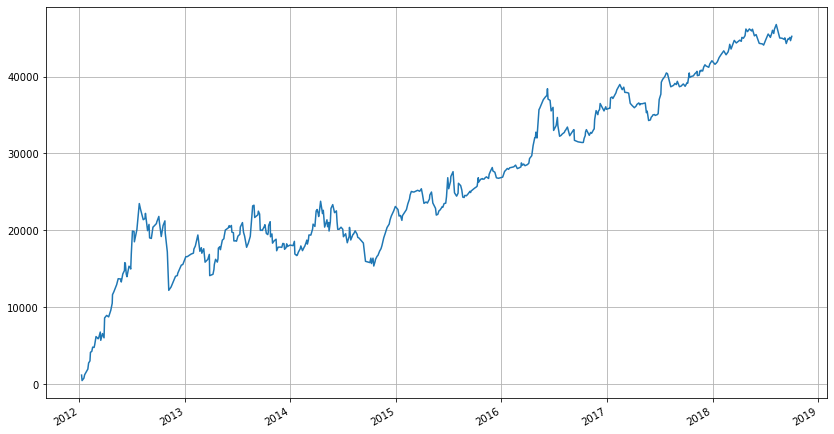

Wall time: 1min 39s


In [129]:
INSTRUMENT = 2  # 1: equity, 2: future, 3: crypto/forex
CAPITAL = 1  # money per trade (case INSTRUMENTS = 1,3) or number of contracts (case INSTRUMENTS = 2)
BIGPOINTVALUE = bigpointvalue
COSTS_FIXED = 0 #25

TIME_EXIT = 2
DIRECTION = "long"

POPULATION_SIZE = 500
NUM_GENERATIONS = 50

DNA_SIZE = 6
BEST_DNA_RATIO = 0.2
CROSS_DNA_RATIO = 0.2
MUTATION_PROB = 0.1
OOS = 500  #### in barre

# Profit
# AvgTrade
# ProfitFactor
# GrossProfit
# Profit/MaxDrawDown
# AvgTrade/MaxDrawDown
# clone ### addestramento su equity 
FITNESS_FUNCTION = "clone"
MIN_OPERATIONS = 500

INSTABILITY_FACTOR = 0.0

np.random.seed(None)

population = first_generation()

# Conversioni per Numba
rules_array = rules.values.T
open_array = dataset.open.values
close_array = dataset.close.values
times_array = dataset.index.values
gains_array = target(DIRECTION,TIME_EXIT,dataset) 

perfect_equity=pd.Series(index=dataset.index,data=gains_array)
perfect_equity=perfect_equity[perfect_equity>100]


%time best_dnas = evolution()

In [130]:
# stampa dei primi 10 DNA (i migliori delle prime 10 generazioni)
best_dnas

[array([5537, 10604, 10162, 10944, 11875, 11536], dtype=object),
 array([5537, 10604, 10162, 6428, 11875, 128], dtype=object),
 array([3636, 10604, 10162, 10944, 11875, 11536], dtype=object),
 array([12008, 10604, 3198, 10944, 11875, 11536], dtype=object),
 array([12008, 10604, 3198, 10944, 11875, 11536], dtype=object),
 array([7552, 10604, 10162, 6428, 11875, 128], dtype=object),
 array([7552, 10604, 10162, 6428, 11875, 128], dtype=object),
 array([7552, 10604, 10162, 10944, 11875, 128], dtype=object),
 array([4558, 10604, 3198, 6428, 5482, 11536], dtype=object),
 array([4558, 10604, 3198, 6428, 5482, 11536], dtype=object),
 array([4558, 10604, 3198, 6428, 5482, 11536], dtype=object),
 array([4558, 10604, 3198, 6428, 5482, 7940], dtype=object),
 array([4558, 10604, 3198, 11501, 5482, 11536], dtype=object),
 array([4558, 10604, 3198, 11501, 5482, 11536], dtype=object),
 array([4558, 10604, 3198, 11501, 5482, 11536], dtype=object),
 array([4558, 10604, 3198, 11501, 5482, 11536], dtype=o

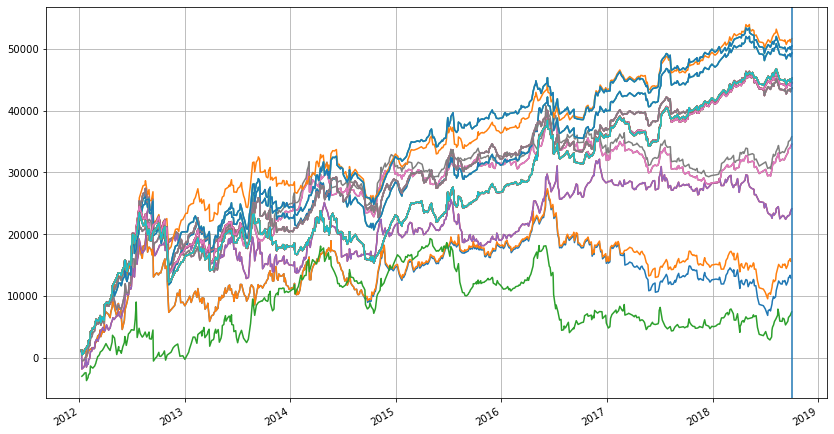

In [131]:
for el in best_dnas:
    plot_equity(el)
plt.axvline(x=dataset.iloc[:-500].index[-1])

In [132]:
# stampa la fitness del miglior DNA dell'ultima generazione
last_dna = best_dnas[-1]
fitness(last_dna)

57.171314741035864

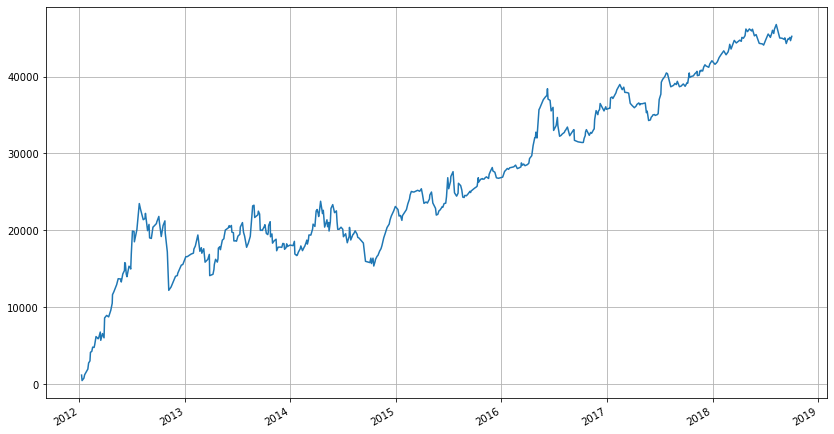

In [133]:
plot_equity(last_dna)
#plot_equity(best_dnas[0])


In [134]:
dataset["entry_rule"] = eval(dna_formula(last_dna)) #############setups(numba.typed.List(last_dna))  #eval(formula)  eval(dna_formula(last_dna)) #setups(numba.typed.List(last_dna))  #eval(formula) 

level = "dataset.close.shift(1)"
ADD_RULE_CONDITION = "False" 


NAME = "Tester"

WRITELOG = False

EXIT_ON_ENTRY_BAR = False
CONSECUTIVE_TRADES = True

COSTS_FIXED = 0#25.0
# 10 for 10 $ for each transaction (2 * fee each operation)
COSTS_VARIABLE = 0.0
# 1.0 for 1% (2 * fee each operation)
COSTS_PERSHARES = 0.0 
# 0.01 for 1 cent for each shares traded (2 * fee each operation)

INSTRUMENT = 2 # 1: equity, 2: future, 3: crypto/forex
TICK = tick
BIGPOINTVALUE = BIGPOINTVALUE
ORDER_TYPE = "market"
MAX_INTRADAY_OPERATIONS = 100

QUANTITY = 1
MARGIN_PERCENT = 10 # margin to use in capital calculation

TIME_EXIT = TIME_EXIT  # 0 to disable
TIME_EXIT_LOSS = 0  # 0 to disable
TIME_EXIT_GAIN = 0  # 0 to disable

MONEY_STOPLOSS = 0  # 0 to disable
MONEY_TARGET = 0  # 0 to disable

MIN_MONEY_PERCENT_STOPLOSS = 0
PERCENT_STOPLOSS = 0.0  # 0 to disable

MIN_MONEY_PERCENT_TARGET = 0
PERCENT_TARGET = 0.0  # 0 to disable

enter_level = eval(level)

exit_rules_loss = False

exit_rules_gain = False 

target_level = 0 # 0 to disable

stop_level = 0 # 0 to disable

DIRECTION = DIRECTION
enter_rules = dataset["entry_rule"]
exit_rules = False

tradelist_l, open_equity_l, closed_equity_l, operation_equity_l = apply_trading_system(dataset.iloc[:-1], INSTRUMENT, QUANTITY, MARGIN_PERCENT, BIGPOINTVALUE, TICK, DIRECTION,
                                                                               COSTS_FIXED, COSTS_VARIABLE, COSTS_PERSHARES, 
                                                                               ORDER_TYPE, enter_level, enter_rules, MAX_INTRADAY_OPERATIONS, 
                                                                               exit_rules, exit_rules_loss, exit_rules_gain,
                                                                               target_level, stop_level,
                                                                               TIME_EXIT, TIME_EXIT_LOSS, TIME_EXIT_GAIN, 
                                                                               MONEY_STOPLOSS, MONEY_TARGET, 
                                                                               PERCENT_STOPLOSS, MIN_MONEY_PERCENT_STOPLOSS, 
                                                                               PERCENT_TARGET, MIN_MONEY_PERCENT_TARGET, WRITELOG, EXIT_ON_ENTRY_BAR, CONSECUTIVE_TRADES)

# True: Interactive, False: Static
#performance_report(dataset, tradelist_l, closed_equity_l, open_equity_l, 100000, 0, MARGIN_PERCENT, False)


Elaboration starting at: 2023-01-05 11:08:13.077843
Elaboration completed at: 2023-01-05 11:08:13.079844 in 0:00:00.002001

Consistency check: entries: 606 exits: 606

Last trade still open: we close it on last bar and we compute open position as closed position!



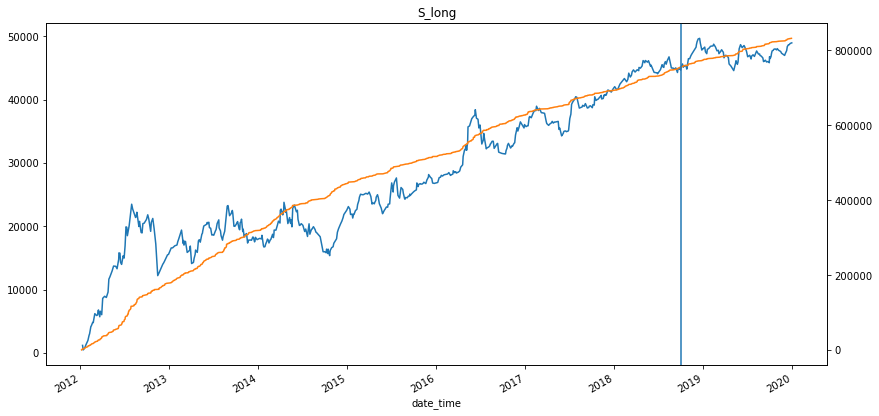

In [135]:
tradelist_l.operations.cumsum().plot(figsize=(14,7),title=SIMBOLO+"_"+DIRECTION)
perfect_equity.cumsum().plot(figsize=(14,7),secondary_y=True)
plt.axvline(x=dataset.iloc[:-OOS].index[-1])

In [136]:
######################## SALVA I DATI LONG

report=performance_report_gen(tradelist_l.operations)
report["TP"]=int(tradelist_l.operations.quantile(0.95))
report["SL"]=int(abs(tradelist_l.operations.quantile(0.05)))

long=tradelist_l.operations
info_long=pd.DataFrame([bigpointvalue,tick,SIMBOLO,utc_offset,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE,str(custom_session_start),str(custom_session_stop),costi,DIRECTION,ORDER_TYPE,dna_formula(last_dna),TIME_EXIT,level,ADD_RULE_CONDITION]).T
info_long=pd.concat([info_long,report],axis=1)

In [128]:
######################## SALVA I DATI SHORT

report=performance_report_gen(tradelist_l.operations)
report["TP"]=int(tradelist_l.operations.quantile(0.95))
report["SL"]=int(abs(tradelist_l.operations.quantile(0.05)))

short=tradelist_l.operations
info_short=pd.DataFrame([bigpointvalue,tick,SIMBOLO,utc_offset,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE,str(custom_session_start),str(custom_session_stop),costi,DIRECTION,ORDER_TYPE,dna_formula(last_dna),TIME_EXIT,level,ADD_RULE_CONDITION]).T
info_short=pd.concat([info_short,report],axis=1)

In [137]:
ptf=pd.concat([long,short],axis=1).fillna(0)
ptf.columns=(["long","short"])

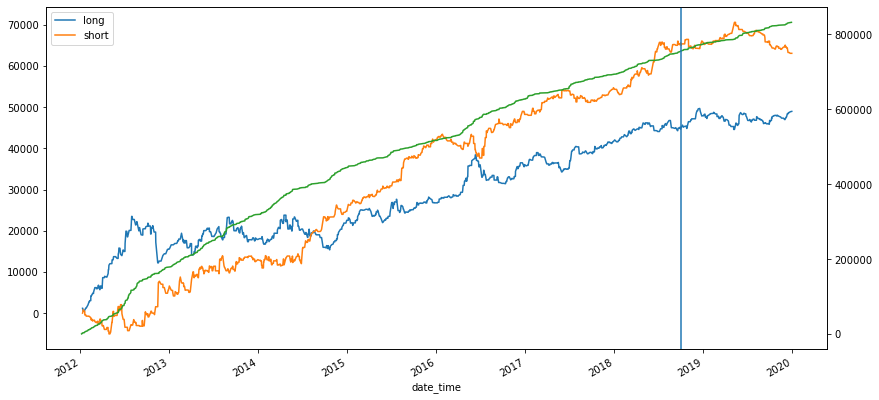

In [138]:
ptf.cumsum().plot(figsize=(14,7))
perfect_equity.cumsum().plot(figsize=(14,7),secondary_y=True)
plt.axvline(x=dataset.iloc[:-500].index[-1])

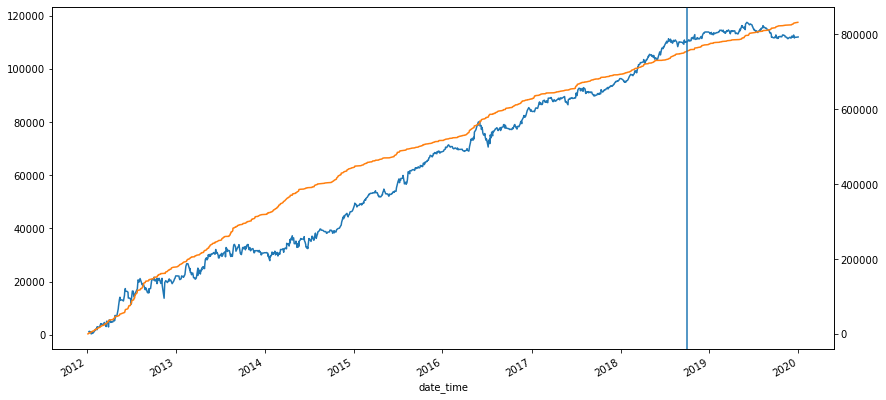

In [139]:
ptf.sum(axis=1).cumsum().plot(figsize=(14,7))
perfect_equity.cumsum().plot(figsize=(14,7),secondary_y=True)
plt.axvline(x=dataset.iloc[:-500].index[-1])

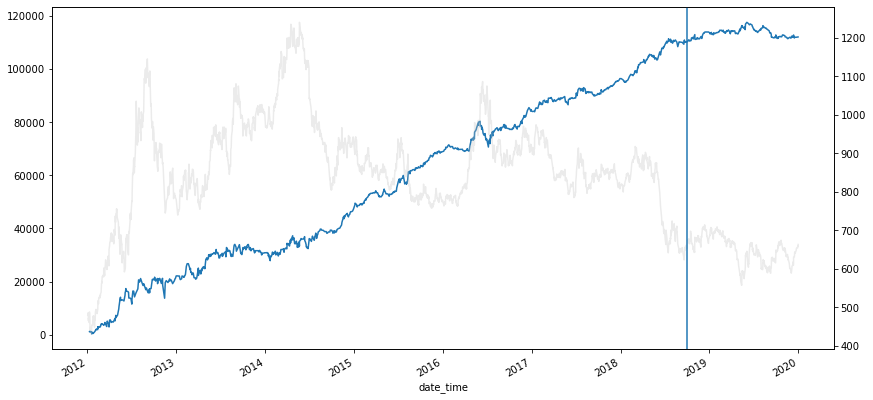

In [143]:
ptf.sum(axis=1).cumsum().plot(figsize=(14,7))
dataset.close.plot(figsize=(14,7),secondary_y=True, color="silver", alpha=0.3)
plt.axvline(x=dataset.iloc[:-500].index[-1])

In [141]:
csv_export=pd.DataFrame()
csv_export=pd.concat([csv_export,info_long,info_short])
csv_export

,0,1,2,3,4,5,6,7,8,9,...,Operations,AverageTrade,ProfitFactor,PctWin,KestnerRatio,STD_Daily,Skew,Reward_Risk_Ratio,TP,SL
0,50,0.25,S,CST6CDT,0,480min,2012-01-01,2020-01-01,0830,1315,...,606,80.84,1.35,62.05,0.37,360.068950,-0.573333,0.82,1159,1325
0,50,0.25,S,CST6CDT,0,480min,2012-01-01,2020-01-01,0830,1315,...,612,103.08,1.46,49.18,0.65,367.199825,1.528226,1.51,1561,975


In [142]:
import os
os.chdir(r"C:\Users\Drako\Genetico_V3\Strategie_LS")

import uuid

idz = uuid.uuid1()
save_as = SIMBOLO+"_system_"+RESAMPLE_TF+"_"+str(idz)+".csv"
csv_export.to_csv(save_as)